In [172]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

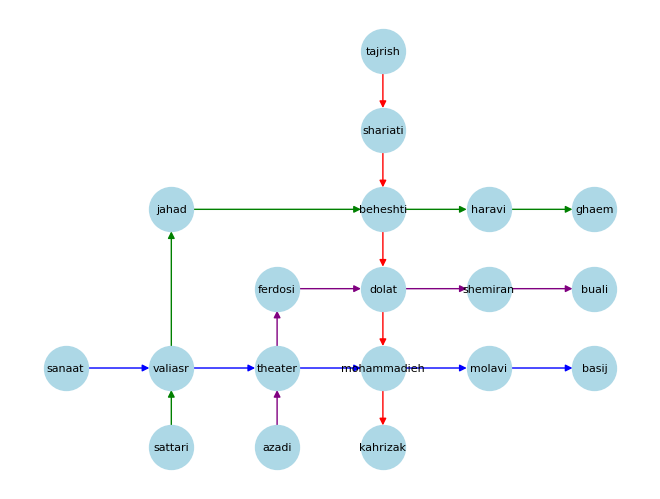

In [173]:
r=["tajrish", "shariati","beheshti","dolat","mohammadieh","kahrizak"]
b=["sanaat","valiasr","theater","mohammadieh","molavi","basij"]
g=["sattari","valiasr","jahad","beheshti","haravi","ghaem"]
p=["azadi","theater","ferdosi","dolat","shemiran","buali"]

# create a directed graph object
G = nx.DiGraph()

# add some edges representing metro lines with distinct colors
G.add_edges_from([(r[i], r[i+1],{'line': 'red'}) for i in range(len(r)-1)]+
                 [(b[i], b[i+1],{'line': 'blue'}) for i in range(len(b)-1)]+
                    [(g[i], g[i+1],{'line': 'green'}) for i in range(len(g)-1)]+
                    [(p[i], p[i+1],{'line': 'purple'}) for i in range(len(p)-1)])


# set the position of the nodes
pos = {
    'Tajrish': (3, 5),
    'Shariati': (3, 4),
    'Beheshti': (3, 3),
    'Dolat': (3, 2),
    'mohammadieh': (3, 1),
    'Kahrizak': (3, 0),
    'Sanaat': (0, 1),
    'Valiasr': (1, 1),
    'theater': (2, 1),
    'Molavi': (4, 1),
    'Basij': (5, 1),
    'Sattari': (1,0),
    'Jahad': (1,3),
    'Haravi': (4, 3),
    'Ghaem': (5, 3),
    'Azadi': (2, 0),
    'Ferdosi': (2, 2),
    'Shemiran': (4, 2),
    'Buali': (5, 2)}

#lower case the keys of the dictionary
pos = {k.lower(): v for k, v in pos.items()}

# draw the graph
nx.draw(G, pos, with_labels=True,font_size=8,
         node_size=1000, node_color="lightblue",
           edge_color=[G[u][v]['line'] for u, v in G.edges()])

In [174]:
# set station rates
sr=dict()
for n in G.nodes():
    if G.in_degree(n) == 0:
        sr[n]=[np.random.randint(30,40+1),"None"]
    elif G.out_degree(n) == 0:
        sr[n]=["None","all"]
    elif G.in_degree(n)>1:
        sr[n]=[np.random.randint(10,14+1),
               np.random.randint(15,20+1)]
    else:
        sr[n]=[np.random.randint(10,14+1),
               np.random.randint(8,12+1)]
sr

{'tajrish': [36, 'None'],
 'shariati': [13, 12],
 'beheshti': [12, 19],
 'dolat': [14, 16],
 'mohammadieh': [12, 17],
 'kahrizak': ['None', 'all'],
 'sanaat': [40, 'None'],
 'valiasr': [14, 18],
 'theater': [12, 20],
 'molavi': [14, 9],
 'basij': ['None', 'all'],
 'sattari': [37, 'None'],
 'jahad': [13, 9],
 'haravi': [13, 12],
 'ghaem': ['None', 'all'],
 'azadi': [30, 'None'],
 'ferdosi': [13, 9],
 'shemiran': [14, 11],
 'buali': ['None', 'all']}

In [175]:
def rate2in(x):
    if x == "None":
        return 0
    else:
        return np.random.poisson(x)
    
def rate2out(x,line_before=-1):
    if x == "None":
        return 0
    elif x == "all":
        return line_before
    else:
        out=np.random.poisson(x)
        return min(out,line_before)

In [176]:
# find sibilings of a node
def siblings(node,parent):
    temp=list(G.successors(parent))
    temp.remove(node)
    return temp[0]

#check order of two stations
Nodes=list(G.nodes())
def check_order(s1,s2):
    if Nodes.index(s1) < Nodes.index(s2):
        return True
    elif Nodes.index(s1) > Nodes.index(s2):
        return False
    else:
        raise ValueError("Two stations are the same")

In [177]:
# building dataset by simulation
dict_of_ds=dict()
for d in range(1,30+1):
    print(f'It is day: {d}!')
    ds = pd.DataFrame(columns=['day','daily time',
                           'station','in','out',
                           'line_before','line_after',
                           'trains'])
    for t in range(0,6*10*16+1,6):
        for n in G.nodes:
            if G.in_degree(n)==0 and t<=930:
                inp=rate2in(sr[n][0])
                out=rate2out(sr[n][1])
                ds.loc[len(ds)] = [d,t,n,inp,out,0,0+inp-out,1]
            else:
                line_before=0
                t_n=0
                parent_n=list(G.predecessors(n))
                window=ds[(ds["daily time"]==t-6) & (ds["station"].isin(parent_n))]
                for pn in parent_n:
                    w=window[window["station"]==pn]
                    t_pn=w["trains"].sum()
                    if t_pn>0:
                        temp=w["line_after"].sum()
                        if t_pn==1 and G.out_degree(pn)==1:
                            line_before+=temp
                            t_n+=1
                        elif t_pn==2 and G.out_degree(pn)==2:
                            if temp%2==0:
                                line_before+=temp//2
                            elif check_order(n,siblings(n,pn)):
                                line_before+=temp//2+1
                            else:
                                line_before+=temp//2
                            t_n+=1
                        elif check_order(n,siblings(n,pn)):
                            line_before+=temp
                            t_n+=1
                if t_n>0:
                    inp=rate2in(sr[n][0])
                    out=rate2out(sr[n][1],line_before)
                    ds.loc[len(ds)] = [d,t,n,inp,out,line_before,line_before+inp-out,t_n]
    dict_of_ds[d]=ds

# merge dataframes
ds=pd.concat([dict_of_ds[i] for i in list(dict_of_ds.keys())],ignore_index=True)


It is day: 1!
It is day: 2!
It is day: 3!
It is day: 4!
It is day: 5!
It is day: 6!
It is day: 7!
It is day: 8!
It is day: 9!
It is day: 10!
It is day: 11!
It is day: 12!
It is day: 13!
It is day: 14!
It is day: 15!
It is day: 16!
It is day: 17!
It is day: 18!
It is day: 19!
It is day: 20!
It is day: 21!
It is day: 22!
It is day: 23!
It is day: 24!
It is day: 25!
It is day: 26!
It is day: 27!
It is day: 28!
It is day: 29!
It is day: 30!


In [178]:
ds

,day,daily time,station,in,out,line_before,line_after,trains
0,1,0,tajrish,34,0,0,34,1
1,1,0,sanaat,30,0,0,30,1
2,1,0,sattari,36,0,0,36,1
3,1,0,azadi,33,0,0,33,1
4,1,6,tajrish,37,0,0,37,1
...,...,...,...,...,...,...,...,...
88945,30,954,buali,0,34,34,0,1
88946,30,960,mohammadieh,11,15,25,21,1
88947,30,960,kahrizak,0,29,29,0,1
88948,30,960,basij,0,30,30,0,1


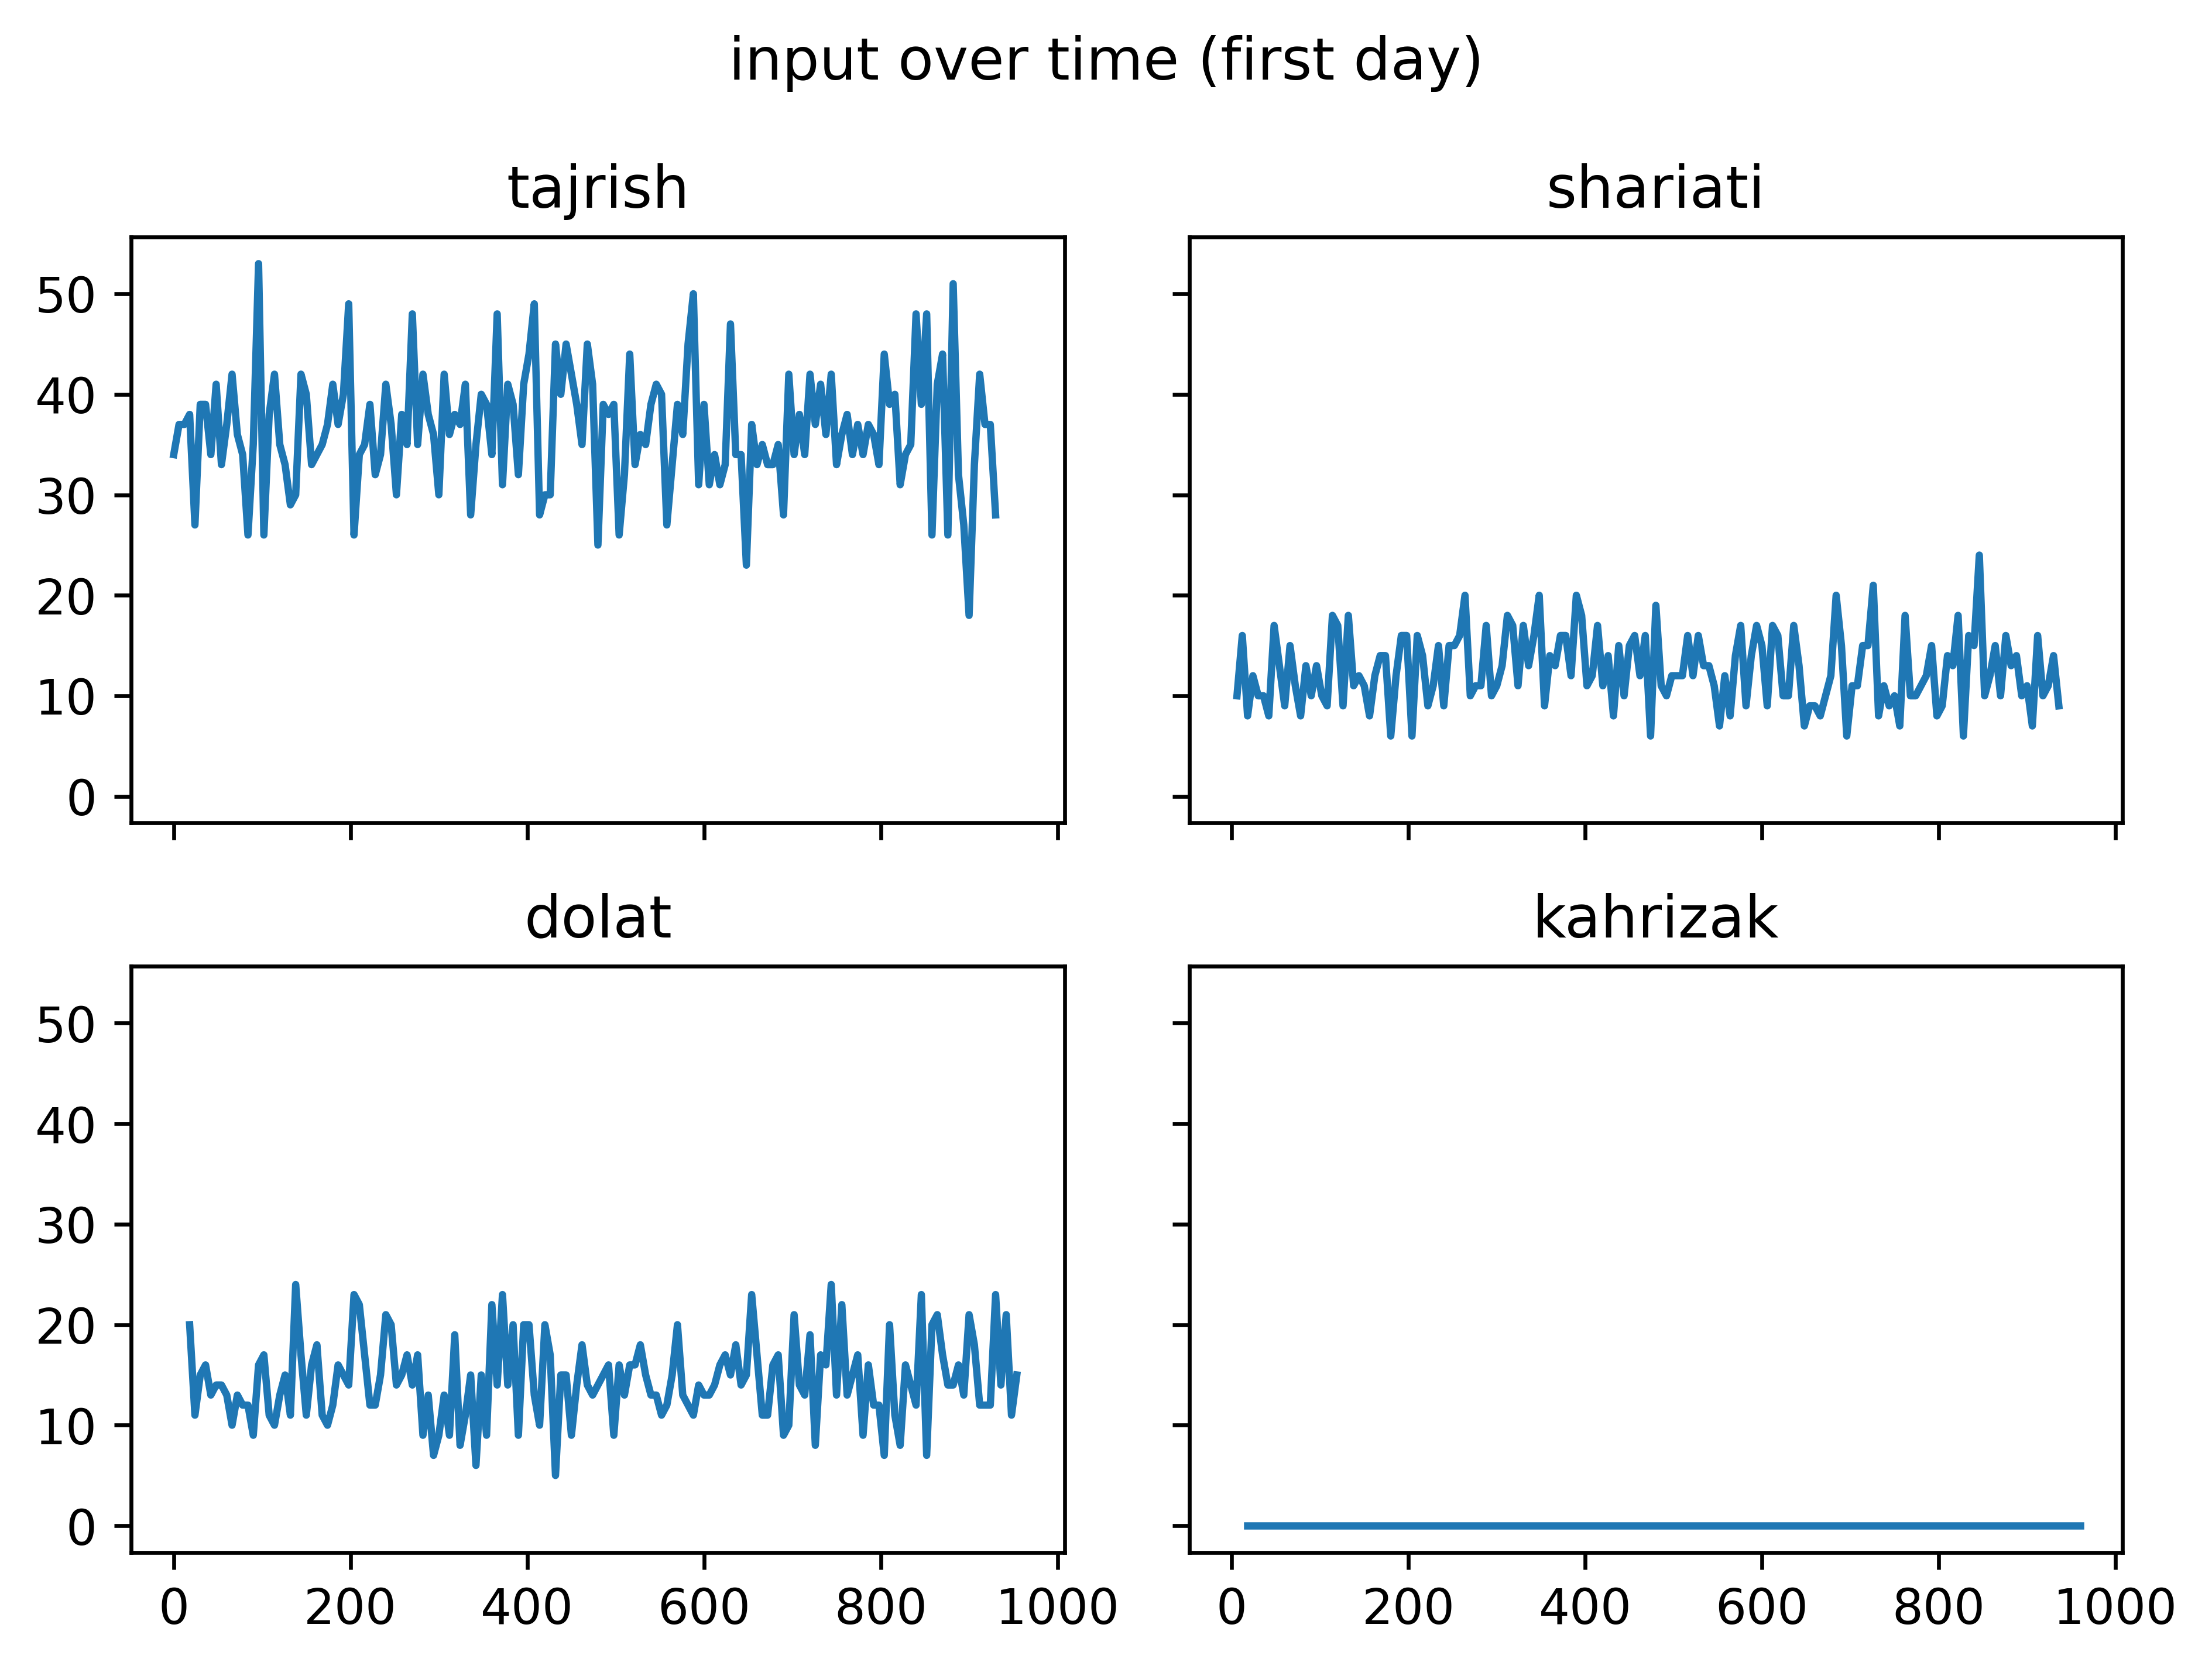

In [179]:
# plot input over time (first day)
fig, axs = plt.subplots(2, 2,tight_layout=True, sharex=True, sharey=True,dpi=600)
axs=axs.flat
# set title
fig.suptitle('input over time (first day)')

n_plot=["tajrish", "shariati","dolat","kahrizak"]

for ax,n in zip(axs,n_plot):
    temp=ds[(ds["station"]==n) & (ds["day"]==1)]
    ax.plot(temp["daily time"].to_numpy(),
            temp["in"].to_numpy())
    ax.title.set_text(n)

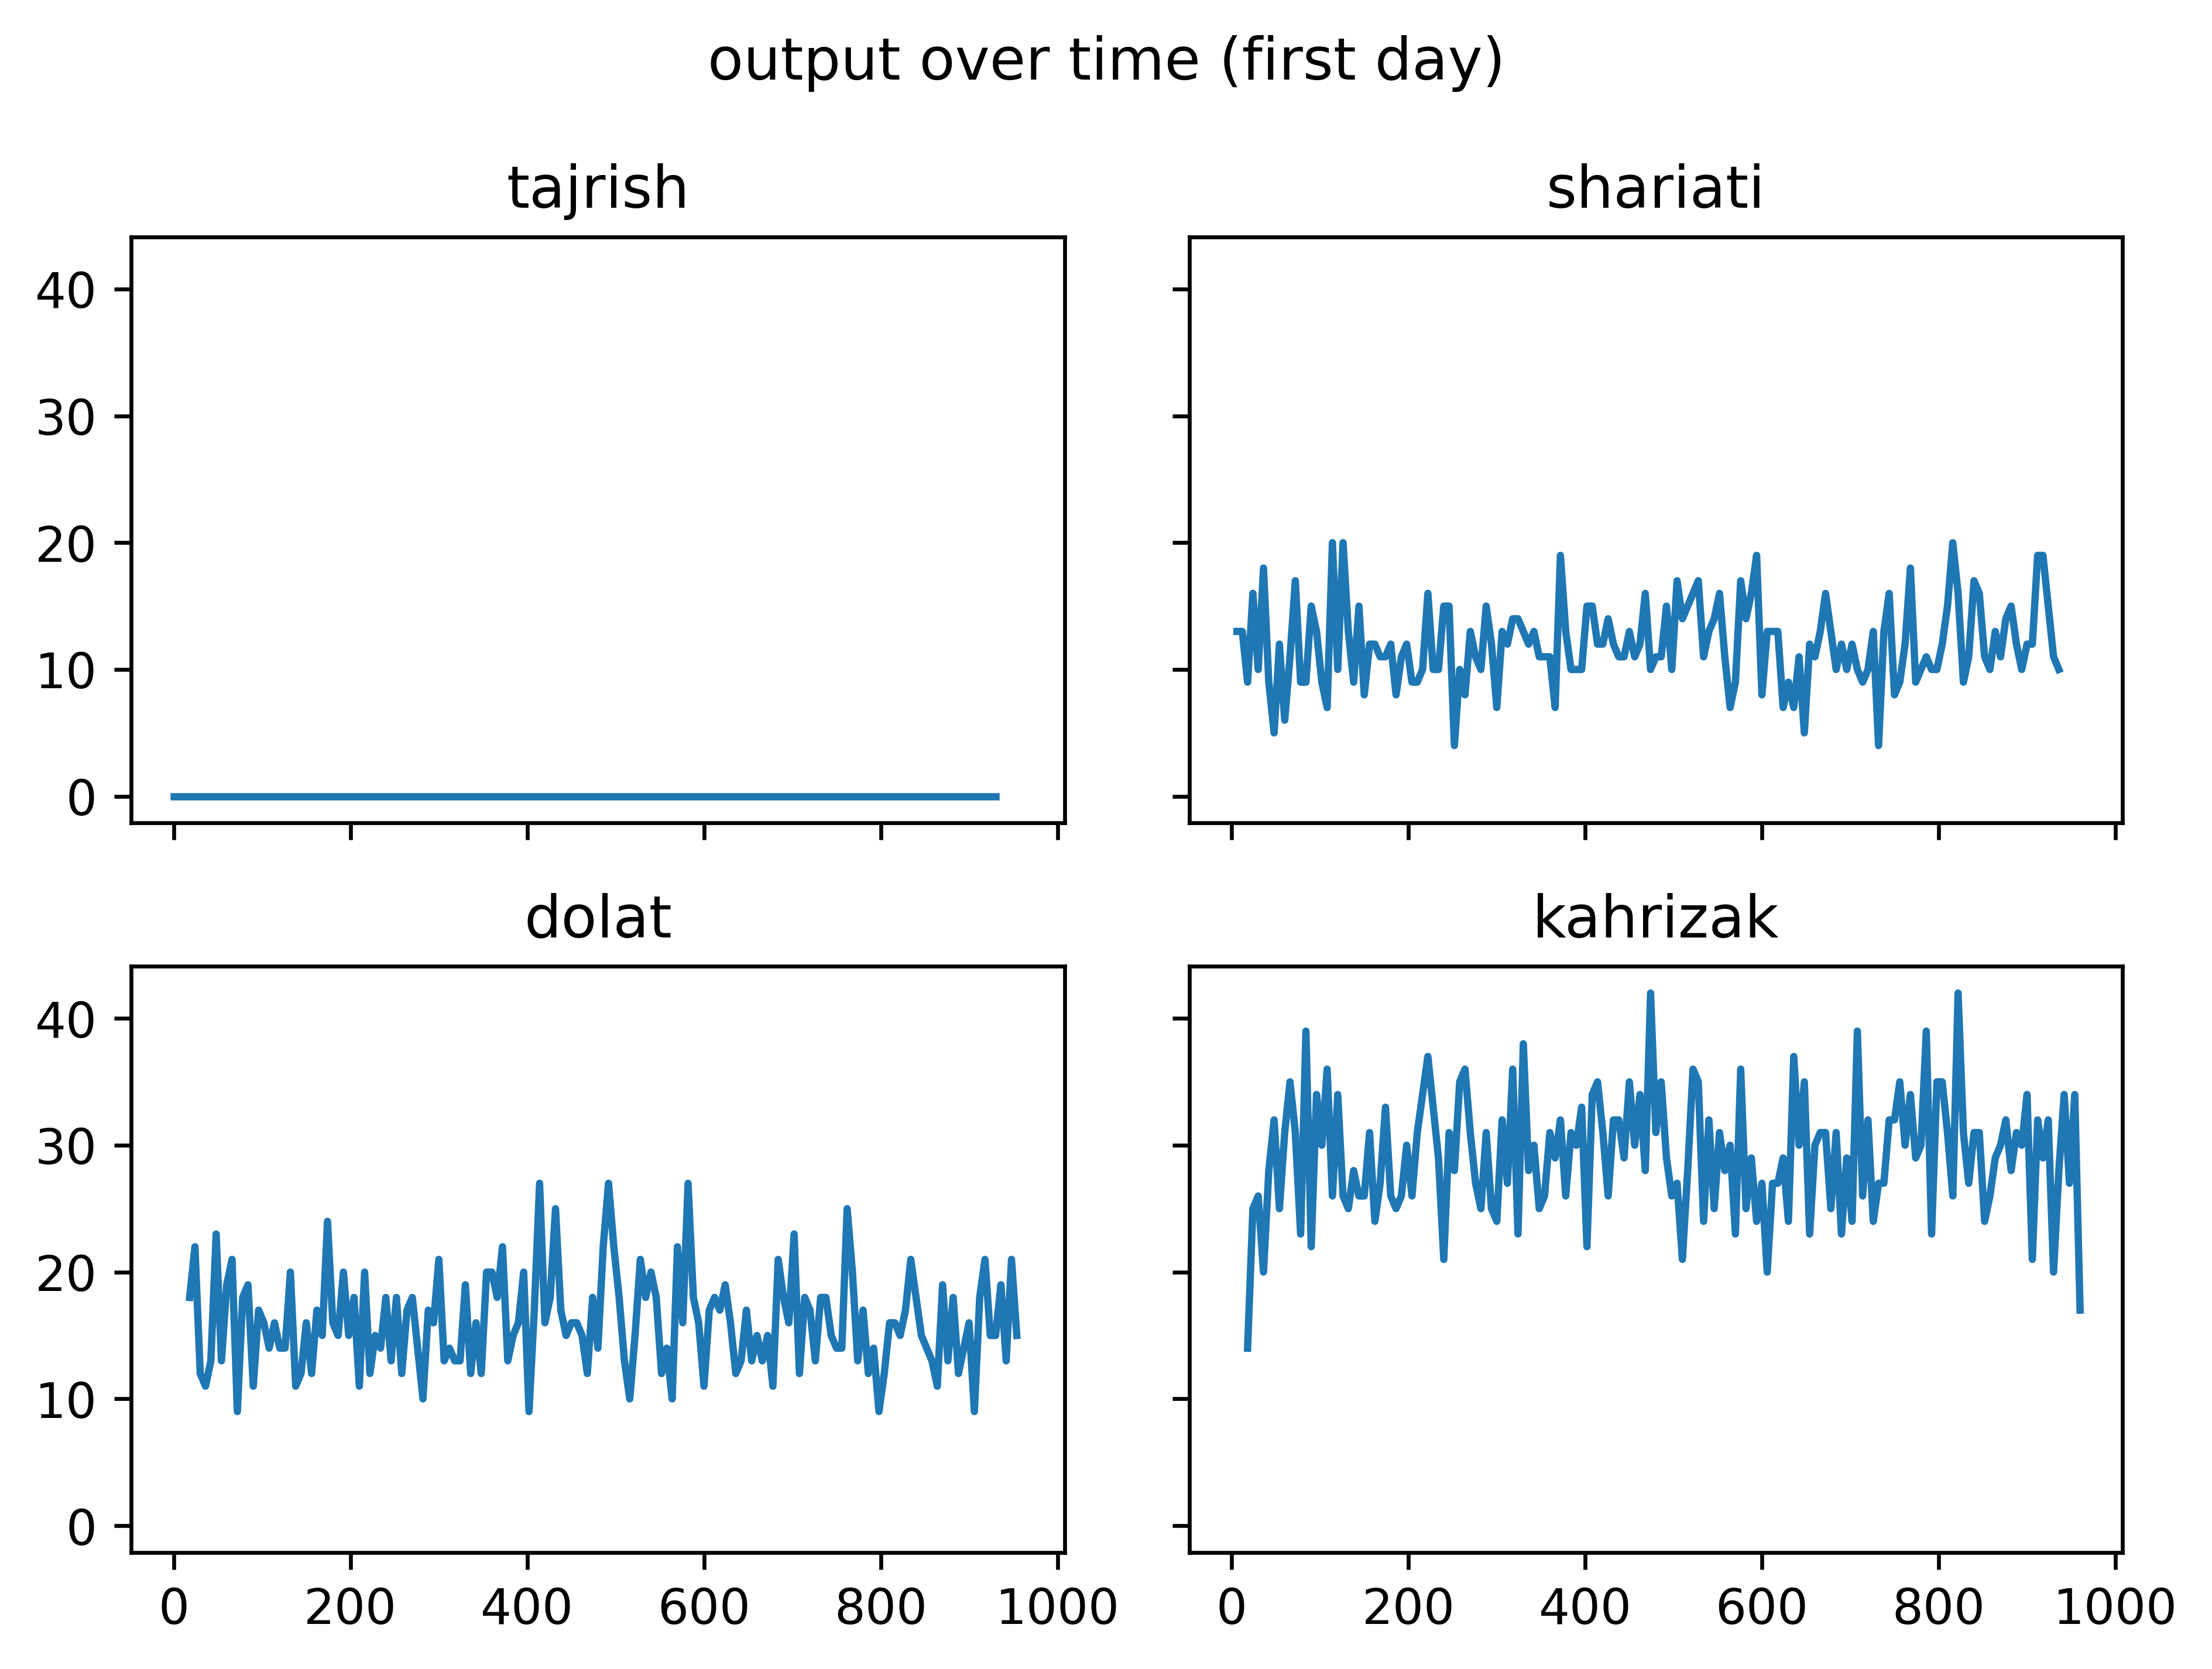

In [180]:
# plot output over time (first day)
fig, axs = plt.subplots(2, 2,tight_layout=True, sharex=True, sharey=True,dpi=600)
axs=axs.flat
# set title
fig.suptitle('output over time (first day)')

n_plot=["tajrish", "shariati","dolat","kahrizak"]

for ax,n in zip(axs,n_plot):
    temp=ds[(ds["station"]==n) & (ds["day"]==1)]
    ax.plot(temp["daily time"].to_numpy(),
            temp["out"].to_numpy())
    ax.title.set_text(n)

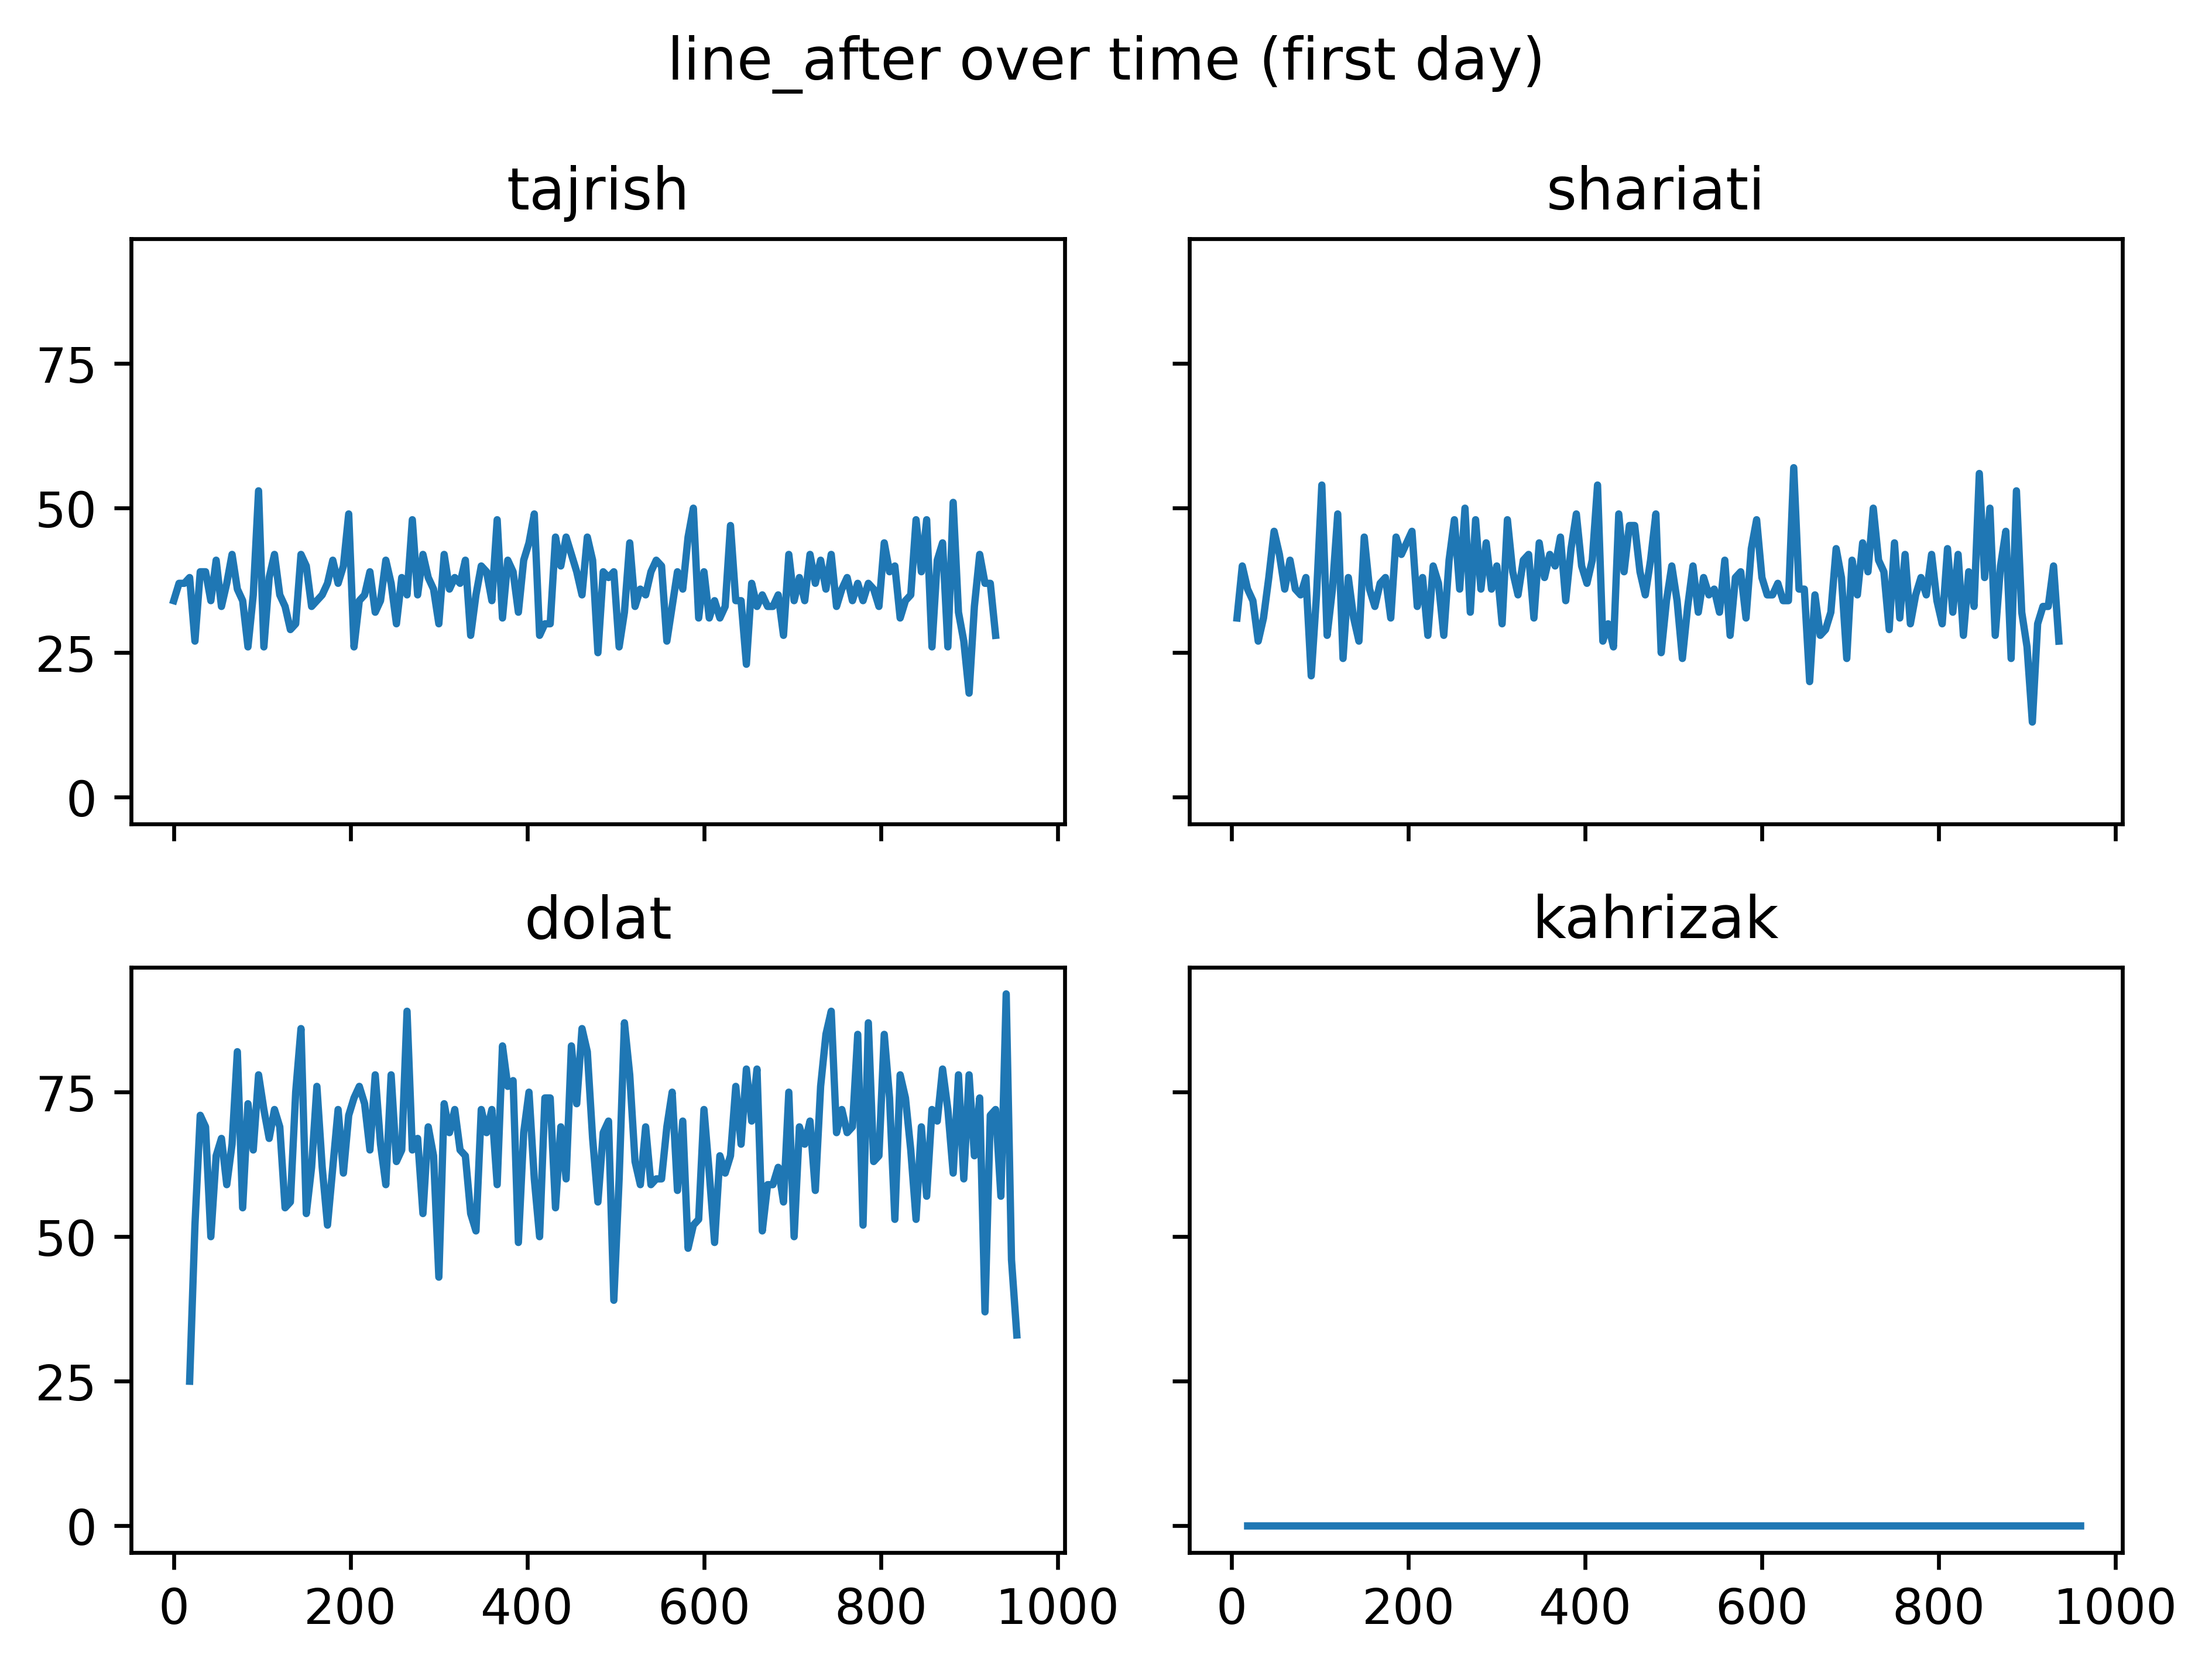

In [181]:
# plot line_after over time (first day)
fig, axs = plt.subplots(2, 2,tight_layout=True, sharex=True, sharey=True,dpi=600)
axs=axs.flat
# set title
fig.suptitle('line_after over time (first day)')

n_plot=["tajrish", "shariati","dolat","kahrizak"]

for ax,n in zip(axs,n_plot):
    temp=ds[(ds["station"]==n) & (ds["day"]==1)]
    ax.plot(temp["daily time"].to_numpy(),
            temp["line_after"].to_numpy())
    ax.title.set_text(n)

In [182]:
# one hot encoding for stations
ds_new=ds.copy()

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer(sparse_output=False).fit(ds_new["station"])
ds_new = pd.concat([ds_new,
                    pd.DataFrame(enc.transform(pd.DataFrame(ds_new["station"])),
                                 columns=enc.classes_)],
                                   axis=1)
del ds_new["station"]
ds_new

,day,daily time,in,out,line_before,line_after,trains,azadi,basij,beheshti,...,kahrizak,mohammadieh,molavi,sanaat,sattari,shariati,shemiran,tajrish,theater,valiasr
0,1,0,34,0,0,34,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,30,0,0,30,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,36,0,0,36,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,33,0,0,33,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,37,0,0,37,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88945,30,954,0,34,34,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88946,30,960,11,15,25,21,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88947,30,960,0,29,29,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
88948,30,960,0,30,30,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
# fit model to predicating out

ds_train,ds_test=train_test_split(
    ds_new, test_size=0.2, random_state=42)

X_col=[col for col in ds_new.columns
        if col not in ["in","out","line_before","line_after","trains"]]
y_col="out"

X_train=ds_train[X_col].to_numpy()
y_train=(ds_train[y_col].to_numpy()).ravel()
X_test=ds_test[X_col].to_numpy()
y_test=(ds_test[y_col].to_numpy()).ravel()

m=LinearRegression().fit(X_train,y_train)
print(mean_squared_error(y_test,m.predict(X_test)))

# example of prediction for a specific time and station
m.predict(np.concatenate([np.array([[15,360]]),enc.transform(["azadi"])],axis=1))

17.50727590244313


array([-0.0094351])

In [184]:
# fit model to predicating in
y_col="in"
y_train=(ds_train[y_col].to_numpy()).ravel()
y_test=(ds_test[y_col].to_numpy()).ravel()

m=LinearRegression().fit(X_train,y_train)
print(mean_squared_error(y_test,m.predict(X_test)))

# example of prediction for a specific time and station
m.predict(np.concatenate([np.array([[15,360]]),enc.transform(["azadi"])],axis=1))

15.298363073639521


array([29.94486964])

In [185]:
ds_system_trafic=ds[["day","daily time","line_after"]].groupby(["day","daily time"],
                                                               as_index=False).sum()
ds_system_trafic

,day,daily time,line_after
0,1,0,133
1,1,6,250
2,1,12,361
3,1,18,493
4,1,24,553
...,...,...,...
4825,30,936,549
4826,30,942,380
4827,30,948,222
4828,30,954,117


In [186]:
# fit model to predicating line trafic
ds_train,ds_test=train_test_split(
    ds_system_trafic, test_size=0.2, random_state=42)

X_col=[col for col in ds_system_trafic.columns
        if col not in ["line_after"]]
y_col="line_after"

X_train=ds_train[X_col].to_numpy()
y_train=(ds_train[y_col].to_numpy()).ravel()
X_test=ds_test[X_col].to_numpy()
y_test=(ds_test[y_col].to_numpy()).ravel()

m=AdaBoostRegressor(random_state=42).fit(X_train,y_train)
print(mean_squared_error(y_test,m.predict(X_test)))
# example of prediction for a specific time
m.predict(np.array([[30,0]]))

1339.5189082249503


array([141.85714286])

In [187]:
# estimate the in and out rates
ds.groupby("station").agg({"in":"mean","out":"mean"})

,in,out
station,,
azadi,29.911752,0.000000
basij,0.000000,33.742581
beheshti,12.063270,19.125053
buali,0.000000,35.957634
dolat,13.986412,16.063907
ferdosi,13.036344,9.004301
ghaem,0.000000,35.945161
haravi,13.045806,12.000860
jahad,12.992949,9.008120
